# Post-Earnings Announcement Drift
<p class="lead">This script provides a sample methodology for calculating Earnings Surprises using Compustat and IBES data, and then constructing Post-Earnings Announcement Drift (PEAD) portfolios based on the estimates of earnings surprises.</p>
## Post-Earnings Announcement Drift
Post-earnings announcement drift (PEAD) is the tendency for a stock’s cumulative abnormal returns to drift in the direction of an earnings surprise for a certain period of time (usually, several weeks) following the earnings announcement date (EAD). It is one of the best-documented and most-resilient capital market anomalies (along with momentum), which was first discovered by Ball and Brown (1968). The academic profession has subjected the drift anomaly to a battery of tests both in the US and abroad (Booth et al., 1996; Liu et al., 2003), but a rational, economic explanation for the drift remains elusive (Kothari, 2001).

This application follows the methodology outlined in Livnat and Mendenhall (JAR, 2006). Specifically, Compustat-based Earnings Surprise is based on the assumption that EPS follows a seasonal random walk, where the best expectation of the EPS in quarter t is the firm’s reported EPS in the same quarter of the previous fiscal year. Hence, Compustat-based $SUE1$ is defined as follows:

\begin{equation}
SUE1_{jt} = \frac{X_{jt} - X_{jt-4}}{P_{jt}}
\end{equation}

where $X_{jt}$ is primary Earnings Per Share (EPS) before extraordinary items for firm $j$ in quarter $t$, and $P_{jt}$ is the price per share for firm $j$ at the end of quarter $t$ from Compustat. $X_{jt}$ and $P_{jt}$ are unadjusted for share splits, but $X_{jt-4}$ is adjusted for any share splits and share dividends during the period $\{t-4, t\}$ using Compustat adjustment factor (AJEXQ). Depending on whether majority of analyst EPS forecasts are based on primary or diluted basis, we use Compustat’s primary (EPSPXQ) or diluted (EPSFXQ) EPS figures in place of $X_{jt}$ . To link Compustat and IBES, the application relies on 3 building blocks:

1) WRDS Link b/w CRSP Permno and IBES ticker with scores indicating accuracy of the match.

2) CRSP-Compustat Merged product that provides a historical link between CRSP PERMCO/PERMNO and Compustat GVKEY.

3) Header link between Compustat GVKEY and IBES Ticker (IBTIC) provides by Compustat in its SECURITY table.

Due to the fact that EPS reported in Compustat and IBES may differ due to the fact that Compustat’s earnings are based on GAAP, but IBES reports “street” measures of earnings, we also calculate an alternative measure of earnings surprise, $SUE2$. It excludes special items from the Compustat reported actual and should be more closely aligned with the “street” reported actuals in IBES (Abarbanell and Lehavy (2002)). Special items in Compustat are defined as unusual or nonrecurring items and include, among other things, restructuring charges, asset impairments, M&A charges, nonrecurring profits or losses on sale of assets, and investments. To estimate SUE2, we subtract from the Compustat reported actual EPS the amount of special items (SPIQ) times 65%, divided by the number of shares used to calculate primary EPS (CSHPRQ) or diluted EPS (CSHFDQ) (the latter is used if most analyst predict diluted EPS; see Bradshaw and Sloan (2002) for more details on treatment of special items and justification on using “65%” factor).

Ideally, researchers would want to use Compustat Unrestated Quarterly (aka “As First Reported”) data to estimate the earnings surprises and the magnitude of the drift. This application relies, however, on what most WRDS users have subscription to, Compustat Quarterly Restated data. This decision is justified by the fact that that restatements were found to have a very small effect on estimates of the drift (see Livnat and Mendenhall (2006), pp. 188). However, users with subscriptions to Compustat Unrestated data can easily modify the code to use "As First Reported" data instead of restated Compustat to more accurately estimate the Compustat-based earnings surprises.

The third IBES-based measure of earnings surprises, $SUE3$, is defined similarly to Compustat’s $SUE1$, except $X_{jt-4}$ and $X_{jt}$ are replaced with a measure of analyst’s expectations and IBES reported actual “street” earnings, respectively. The measure for analysts’ expectations is the median of latest individual analysts forecasts issued within the 90 days prior to the EAD. In constructing IBES-Based earnings surprises ($SUE3$), the program uses IBES Unadjusted Detail History that does not have adjustments for stock splits and stock dividends. This is done to avoid the potential rounding issues in IBES Adjusted data described in Payne and Thomas (2003). IBES Unadjusted data are rounded to 4 decimals and allows researchers to create their own split-adjusted forecasts and actuals without having to round to the nearest penny. The program shows users how to apply CRSP adjustment factor to put both the forecast and the actual in the IBES Unadjusted data on the same per share basis and to accurately calculate analyst-based $SUE$.

For all EADs that fall on non-trading days, the program adjusts them to the closest trading day using CRSP trading calendar derived from DSI file. This ensures that no earnings announcements are omitted from the sample unless they have a missing return in CRSP. Note that the application can be easily modified to use the returns data from Compustat. This will add to the analysis those firms that report their earnings in Compustat, but happen to list their stock outside of the exchange domain covered by CRSP (i.e., NYSE, AMEX, NASDAQ and ARCA). See the WRDS Research Application on Market-to-book ratio to get an idea of how many firms may be excluded from the analysis when a user uses CRSP returns as opposed to Compustat's security data.

For the sake of brevity and transparency, to gauge the performance of the PEAD portfolios we use abnormal returns (EXRET) defined as returns in excess of CRSP Value-weighted index, but researchers can plug in their own definitions of abnormal returns (e.g., either using DGTW characteristic-based adjustment or CARs/BHARs from running an event study).

## Post Earnings Announcement Drift Code
Some notes before running this code:

This code relies on a linking table before IBES and CRSP (ICLINK), which is invoked in Step 0. The static table "iclink.pkl" was the output of a separate python program ICLINK. Please make sure to run the ICLINK python code before running this PEAD code.
Python is not known for handling large dataset efficiently in memory. As a result of this constraint, most users probably are not able to run the entire sample period (1980-now) in python one shot. Instead, users can break up the sample period into batches by changing start and end date (begdate and enddate) of the program, before finally piecing the outputs together.

In [ ]:
#####################################
# Post Earnings Announcement Drift  #
# Sep 2019                          #
#####################################

import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
import pickle as pkl
from dateutil.relativedelta import *

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

# set sample date range
begdate = '01/01/2010'
enddate = '12/31/2018'

# set CRSP date range a bit wider to guarantee collecting all information
crsp_begdate = '01/01/2009'
crsp_enddate = '12/31/2019'

#################################
# Step 0: Read in ICLINK output #
#################################

# iclink.pkl is the output from the python program iclink
# it contains the linking between crsp and ibes
with open('iclink.pkl', 'rb') as f:
    iclink = pkl.load(f)

##################################
# Step 1. S&P 500 Index Universe #
##################################

# All companies that were ever included in S&P 500 index as an example 
# Linking Compustat GVKEY and IBES Tickers using ICLINK               
# For unmatched GVKEYs, use header IBTIC link in Compustat Security file 

_sp500 = conn.raw_sql(""" select gvkey from comp.idxcst_his where gvkeyx='000003' """)

_ccm = conn.raw_sql(""" select gvkey, lpermco as permco, lpermno as permno, linkdt, linkenddt 
                        from crsp.ccmxpf_linktable 
                        where usedflag=1 and linkprim in ('P', 'C')""")

_ccm[['permco', 'permno']] = _ccm[['permco', 'permno']].astype(int)
_ccm['linkdt'] = pd.to_datetime(_ccm['linkdt'])
_ccm['linkenddt'] = pd.to_datetime(_ccm['linkenddt'])

_sec = conn.raw_sql(""" select ibtic, gvkey from comp.security """)


import datetime
today = datetime.date.today()

# Fill linkenddt missing value (.E in SAS dataset) with today's date
_ccm['linkenddt'] = _ccm.linkenddt.fillna(today)

# Start the sequence of left join
gvkey = pd.merge(_sp500, _ccm, how='left', on=['gvkey'])
gvkey = pd.merge(gvkey, _sec.loc[_sec.ibtic.notna()], how='left', on=['gvkey'])

# high quality links from iclink
# score = 0 or 1
iclink_hq = iclink.loc[(iclink.score <=1)]

gvkey = pd.merge(gvkey, iclink_hq, how='left', on=['permno'])

# fill missing ticker with ibtic
gvkey.ticker = np.where(gvkey.ticker.notnull(), gvkey.ticker, gvkey.ibtic)

# Keep relevant columns and drop duplicates if there is any
gvkey = gvkey[['gvkey', 'permco', 'permno', 'linkdt', 'linkenddt','ticker']]

gvkey = gvkey.drop_duplicates()

# date ranges from gvkey

# min linkdt for ticker and permno combination
gvkey_mindt = gvkey.groupby(['ticker','permno']).linkdt.min().reset_index()

# max linkenddt for ticker and permno combination
gvkey_maxdt = gvkey.groupby(['ticker','permno']).linkenddt.max().reset_index()

# link date range 
gvkey_dt = pd.merge(gvkey_mindt, gvkey_maxdt, how='inner', on=['ticker','permno'])

#######################################
# Step 2. Extract Estimates from IBES #
#######################################

# Extract estimates from IBES Unadjusted file and select    
# the latest estimate for a firm within broker-analyst group
# "fpi in (6,7)" selects quarterly forecast for the current 
# and the next fiscal quarter    

ibes_temp = conn.raw_sql(f"""
                        select ticker, estimator, analys, pdf, fpi, value, fpedats, revdats, revtims, anndats, anntims
                        from ibes.detu_epsus 
                        where fpedats between '{begdate}' and '{enddate}'
                        and (fpi='6' or fpi='7')
                        """, date_cols = ['revdats', 'anndats', 'fpedats'])

# merge to get date range linkdt and linkenddt to fulfill date requirement
ibes_temp = pd.merge(ibes_temp, gvkey_dt, how='left', on=['ticker'])
ibes_temp=ibes_temp.loc[(ibes_temp.linkdt<=ibes_temp.anndats) & (ibes_temp.anndats <= ibes_temp.linkenddt)]

# Count number of estimates reported on primary/diluted basis 

p_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='P']
d_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='D']

p_count = p_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'p_count'})
d_count = d_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'d_count'})

ibes = pd.merge(ibes_temp, d_count, how = 'left', on=['ticker', 'fpedats'])
ibes = pd.merge(ibes, p_count, how='left', on =['ticker','fpedats'])
ibes['d_count'] = ibes.d_count.fillna(0)
ibes['p_count'] = ibes.p_count.fillna(0)

# Determine whether most analysts report estimates on primary/diluted basis
# following Livnat and Mendenhall (2006)                                   

ibes['basis']=np.where(ibes.p_count>ibes.d_count, 'P', 'D')

ibes = ibes.sort_values(by=['ticker','fpedats','estimator','analys','anndats', 'anntims', 'revdats', 'revtims'])\
.drop(['linkdt', 'linkenddt','p_count','d_count', 'pdf', 'fpi'], axis=1)

# Keep the latest observation for a given analyst
# Group by company fpedats estimator analys then pick the last record in the group

ibes_1 = ibes.groupby(['ticker','fpedats','estimator','analys']).apply(lambda x: x.index[-1]).to_frame().reset_index()

# reset index to the old dataframe index for join in the next step
ibes_1=ibes_1.set_index(0)

# Inner join with the last analyst record per group
ibes = pd.merge(ibes, ibes_1[['analys']], left_index=True, right_index=True)

# drop duplicate column
ibes=ibes.drop(['analys_y'], axis=1).rename(columns={'analys_x': 'analys'})

#######################################
# Step 3. Link Estimates with Actuals #
#######################################

# Link Unadjusted estimates with Unadjusted actuals and CRSP permnos  
# Keep only the estimates issued within 90 days before the report date

# Getting actual piece of data
ibes_act = conn.raw_sql(f"""
                        select ticker, anndats as repdats, value as act, pends as fpedats, pdicity
                        from ibes.actu_epsus 
                        where pends between '{begdate}' and '{enddate}'
                        and pdicity='QTR'
                        """, date_cols = ['repdats', 'fpedats'])

# Join with the estimate piece of the data

ibes1 = pd.merge(ibes, ibes_act, how='left', on = ['ticker','fpedats'])
ibes1['dgap'] = ibes1.repdats - ibes1.anndats

ibes1['flag'] = np.where( (ibes1.dgap>=datetime.timedelta(days=0)) & (ibes1.dgap<=datetime.timedelta(days=90)) & (ibes1.repdats.notna()) & (ibes1.anndats.notna()), 1, 0)

ibes1 = ibes1.loc[ibes1.flag==1].drop(['flag', 'dgap', 'pdicity'], axis=1)


# Select all relevant combinations of Permnos and Date

ibes1_dt1 = ibes1[['permno', 'anndats']].drop_duplicates()

ibes1_dt2 = ibes1[['permno', 'repdats']].drop_duplicates().rename(columns={'repdats':'anndats'})

ibes_anndats = pd.concat([ibes1_dt1, ibes1_dt2]).drop_duplicates()

# Adjust all estimate and earnings announcement dates to the closest
# preceding trading date in CRSP to ensure that adjustment factors won't
# be missing after the merge  

# unique anndats from ibes
uniq_anndats = ibes_anndats[['anndats']].drop_duplicates()

# unique trade dates from crsp.dsi
crsp_dats = conn.raw_sql(""" 
                            select date 
                            from crsp.dsi 
                         """, date_cols=['date'])

# Create up to 5 days prior dates relative to anndats

for i in range(0, 5):
    uniq_anndats[i] = uniq_anndats.anndats - datetime.timedelta(days=i)

# reshape (transpose) the df for later join with crsp trading dates

expand_anndats = uniq_anndats.set_index('anndats').stack().reset_index().\
rename(columns={'level_1':'prior', 0:'prior_date'})

# merge with crsp trading dates
tradedates = pd.merge(expand_anndats, crsp_dats, how='left', left_on=['prior_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
tradedates['dgap'] = tradedates.anndats-tradedates.date

# choosing the row with the smallest dgap for a given anndats
tradedates = tradedates.loc[tradedates.groupby('anndats')['dgap'].idxmin()]

tradedates = tradedates[['anndats', 'date']]


# merge the CRSP adjustment factors for all estimate and report dates

# extract CRSP adjustment factors
cfacshr = conn.raw_sql(f"""
                        select permno, date, cfacshr
                        from crsp.dsf
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])

ibes_anndats = pd.merge(ibes_anndats, tradedates, how='left', on = ['anndats'])

ibes_anndats = pd.merge(ibes_anndats, cfacshr, how='left', on=['permno', 'date'])


#########################################
# Step 4. Adjust Estimates with CFACSHR #
#########################################

# Put the estimate on the same per share basis as
# company reported EPS using CRSP Adjustment factors. 
# New_value is the estimate adjusted to be on the 
# same basis with reported earnings.

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', on=['permno', 'anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_ann'})

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', left_on=['permno', 'repdats'], right_on=['permno','anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_rep'})

ibes1['new_value'] = (ibes1.cfacshr_rep/ibes1.cfacshr_ann)*ibes1.value

# Sanity check: there should be one most recent estimate for 
# a given firm-fiscal period end combination 
ibes1 = ibes1.sort_values(by=['ticker','fpedats','estimator','analys']).drop_duplicates()

# Compute the median forecast based on estimates in the 90 days prior to the EAD

grp_permno = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).permno.max().reset_index()

medest = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).new_value.agg(['median','count']).reset_index()
medest = pd.merge(medest, grp_permno, how='inner', on=['ticker','fpedats','basis', 'repdats', 'act'])
medest = medest.rename(columns={'median': 'medest', 'count':'numest'})


######################################
# Step 5. Merge with Compustat Data  #
######################################

# get items from fundq
fundq = conn.raw_sql(f"""
                        select gvkey, fyearq, fqtr, conm, datadate, rdq, epsfxq, epspxq, cshoq, prccq, 
                        ajexq, spiq, cshoq, cshprq, cshfdq, saleq, atq, fyr, datafqtr, cshoq*prccq as mcap  
                        from comp.fundq 
                        where consol='C' and popsrc='D' and indfmt='INDL' and datafmt='STD'
                        and datadate between '{crsp_begdate}' and '{crsp_enddate}' 
                        """, date_cols = ['datadate', 'datafqtr', 'rdq'])

fundq = fundq.loc[((fundq.atq>0) | (fundq.saleq.notna())) & (fundq.datafqtr.notna())]

# Calculate link date ranges for givken gvkey and ticker combination

gvkey_mindt1 = gvkey.groupby(['gvkey', 'ticker']).linkdt.min().reset_index().rename(columns={'linkdt':'mindate'})
gvkey_maxdt1 = gvkey.groupby(['gvkey', 'ticker']).linkenddt.max().reset_index().rename(columns={'linkenddt':'maxdate'})
gvkey_dt1 = pd.merge(gvkey_mindt1, gvkey_maxdt1, how='inner', on=['gvkey','ticker'])


# Use the date range to merge
comp = pd.merge(fundq, gvkey_dt1, how='left', on =['gvkey'])
comp = comp.loc[(comp.ticker.notna()) & (comp.datadate<=comp.maxdate) & (comp.datadate>=comp.mindate)]

# Merge with the median esitmates
comp = pd.merge(comp, medest, how = 'left', left_on=['ticker','datadate'], right_on=['ticker', 'fpedats'])

# Sort data and drop duplicates
comp = comp.sort_values(by=['gvkey','fqtr','fyearq']).drop_duplicates()


###########################
# Step 6. Calculate SUEs  #
###########################

# block handling lag eps

sue = comp.sort_values(by=['gvkey','fqtr','fyearq'])

sue['dif_fyearq'] = sue.groupby(['gvkey', 'fqtr']).fyearq.diff()
sue['laggvkey']   = sue.gvkey.shift(1)

# handling same qtr previous year

cond_year = sue.dif_fyearq==1 # year increment is 1

sue['lagadj']     = np.where(cond_year, sue.ajexq.shift(1), None)
sue['lageps_p']   = np.where(cond_year, sue.epspxq.shift(1), None)
sue['lageps_d']   = np.where(cond_year, sue.epsfxq.shift(1), None)
sue['lagshr_p']   = np.where(cond_year, sue.cshprq.shift(1), None)
sue['lagshr_d']   = np.where(cond_year, sue.cshfdq.shift(1), None)
sue['lagspiq']    = np.where(cond_year, sue.spiq.shift(1), None)

# handling first gvkey

cond_gvkey = sue.gvkey != sue.laggvkey # first.gvkey

sue['lagadj']     = np.where(cond_gvkey, None, sue.lagadj)
sue['lageps_p']   = np.where(cond_gvkey, None, sue.lageps_p)
sue['lageps_d']   = np.where(cond_gvkey, None, sue.lageps_d)
sue['lagshr_p']   = np.where(cond_gvkey, None, sue.lagshr_p)
sue['lagshr_d']   = np.where(cond_gvkey, None, sue.lagshr_d)
sue['lagspiq']    = np.where(cond_gvkey, None, sue.lagspiq)


# handling reporting basis 

# Basis = P and missing are treated the same

sue['actual1'] = np.where(sue.basis=='D', sue.epsfxq/sue.ajexq, sue.epspxq/sue.ajexq)

sue['actual2'] = np.where(sue.basis=='D', \
                            (sue.epsfxq.fillna(0)-(0.65*sue.spiq/sue.cshfdq).fillna(0))/sue.ajexq, \
                            (sue.epspxq.fillna(0)-(0.65*sue.spiq/sue.cshprq).fillna(0))/sue.ajexq
                           )

sue['expected1'] = np.where(sue.basis=='D', sue.lageps_d/sue.lagadj, sue.lageps_p/sue.lagadj)
sue['expected2'] = np.where(sue.basis=='D', \
                              (sue.lageps_d.fillna(0)-(0.65*sue.lagspiq/sue.lagshr_d).fillna(0))/sue.lagadj, \
                              (sue.lageps_p.fillna(0)-(0.65*sue.lagspiq/sue.lagshr_p).fillna(0))/sue.lagadj
                             )

# SUE calculations
sue['sue1'] = (sue.actual1 - sue.expected1) / (sue.prccq/sue.ajexq)
sue['sue2'] = (sue.actual2 - sue.expected2) / (sue.prccq/sue.ajexq)
sue['sue3'] = (sue.act - sue.medest) / sue.prccq

sue = sue[['ticker','permno','gvkey','conm','fyearq','fqtr','fyr','datadate','repdats','rdq', \
           'sue1','sue2','sue3','basis','act','medest','numest','prccq','mcap']]


# Shifting the announcement date to be the next trading day
# Defining the day after the following quarterly EA as leadrdq1

# unique rdq 
uniq_rdq = comp[['rdq']].drop_duplicates()
uniq_rdq.shape

# Create up to 5 days post rdq relative to rdq
for i in range(0, 5):
    uniq_rdq[i] = uniq_rdq.rdq + datetime.timedelta(days=i)

# reshape (transpose) for later join with crsp trading dates
expand_rdq = uniq_rdq.set_index('rdq').stack().reset_index().\
rename(columns={'level_1':'post', 0:'post_date'})

# merge with crsp trading dates
eads1 = pd.merge(expand_rdq, crsp_dats, how='left', left_on=['post_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
eads1['dgap'] = eads1.date-eads1.rdq
eads1 = eads1.loc[eads1.groupby('rdq')['dgap'].idxmin()].rename(columns={'date':'rdq1'})

# create sue_final
sue_final = pd.merge(sue, eads1[['rdq','rdq1']], how='left', on=['rdq'])
sue_final = sue_final.sort_values(by=['gvkey', 'fyearq','fqtr'], ascending=[True, False, False]).drop_duplicates()

#  Filter from Livnat & Mendenhall (2006):                                
#- earnings announcement date is reported in Compustat                   
#- the price per share is available from Compustat at fiscal quarter end  
#- price is greater than $1                                              
#- the market (book) equity at fiscal quarter end is available and is    
# EADs in Compustat and in IBES (if available)should not differ by more  
# than one calendar day larger than $5 mil.                              

sue_final['leadrdq1'] = sue_final.rdq1.shift(1) # next consecutive EAD
sue_final['leadgvkey'] = sue_final.gvkey.shift(1)

# If first gvkey then leadrdq1 = rdq1+3 months
# Else leadrdq1 = previous rdq1

sue_final['leadrdq1'] = np.where(sue_final.gvkey == sue_final.leadgvkey, 
                                  sue_final.rdq1.shift(1), 
                                  sue_final.rdq1 + pd.offsets.MonthOffset(3))

sue_final['dgap'] = (sue_final.repdats - sue_final.rdq).fillna(0)
sue_final = sue_final.loc[(sue_final.rdq1 != sue_final.leadrdq1)]

# Various conditioning for filtering
cond1 = (sue_final.sue1.notna()) & (sue_final.sue2.notna()) & (sue_final.repdats.isna())
cond2 = (sue_final.repdats.notna()) & (sue_final.dgap<=datetime.timedelta(days=1)) & (sue_final.dgap>=datetime.timedelta(days=-1))
sue_final = sue_final.loc[cond1 | cond2]

# Impose restriction on price and marketcap
sue_final = sue_final.loc[(sue_final.rdq.notna()) & (sue_final.prccq>1) & (sue_final.mcap>5)]

# Keep relevant columns
sue_final = sue_final[['gvkey', 'ticker','permno','conm',\
                       'fyearq','fqtr','datadate','fyr','rdq','rdq1','leadrdq1','repdats',\
                       'mcap','medest','act','numest','basis','sue1','sue2','sue3']]


#########################################
# Step 7. Form Portfolios Based on SUE  #
#########################################

# Extract file of raw daily returns around and between EADs and link them 
# to Standardized Earnings Surprises for forming SUE-based portfolios     

# Records from dsf and dsi to calculate exret
dsf = conn.raw_sql(f"""
                        select permno, date, prc, abs(prc*shrout) as mcap, ret from crsp.dsf
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])

dsi = conn.raw_sql(f"""
                    select date, vwretd from crsp.dsi where date between '{crsp_begdate}' and '{crsp_enddate}'
                    """, date_cols=['date'])

ds = pd.merge(dsf, dsi, how='left', on=['date'])
ds['exret'] = ds.ret - ds.vwretd
ds = ds.rename(columns={'vwretd':'mkt'})

# Records from sue_final that meet the condition
sue_final_join = sue_final.loc[(sue_final.rdq.notna()) & (sue_final.leadrdq1.notna()) & (sue_final.permno.notna()) \
                               & (sue_final.leadrdq1-sue_final.rdq1>datetime.timedelta(days=30))]

sue_final_join['lb_date'] = sue_final_join.rdq1-datetime.timedelta(days=5)
sue_final_join['ub_date'] = sue_final_join.leadrdq1+datetime.timedelta(days=5)


# left join ds with sue_final on permno first
# filter in the second step based on date range requirement
crsprets = pd.merge(ds, sue_final_join[['permno','rdq1', 'leadrdq1','sue1','sue2','sue3', 'lb_date','ub_date']], how='left', on=['permno'])

# keep only records that meet the date range requirement
crsprets = crsprets.loc[(crsprets.date<=crsprets.ub_date) & (crsprets.date>=crsprets.lb_date)]
crsprets = crsprets.drop(['lb_date','ub_date'], axis=1)


# Alternative sql version to handle the join step of crsp return and sue_final
# Warning: sql runs very slow on python 

#import sqlite3

#sqlconn = sqlite3.connect(':memory')

#sue_final_join.to_sql('sue_final_join_sql', sqlconn, index=False)
#ds.to_sql('ds_sql', sqlconn, index=False)

#qry_stmt = """
#            select a.*, b.rdq1, b.leadrdq1, b.sue1, b.sue2, b.sue3
#            from ds_sql as a
#            left join sue_final_join_sql as b
#            on a.permno=b.permno and b.lb_date<=a.date<=b.ub_date
#            """

#crsprets = pd.read_sql_query(qry_stmt, sqlconn)

# To estimate the drift, sum daily returns over the period from  
# 1 day after the earnings announcement through the day of       
# the following quarterly earnings announcement       

temp = crsprets.sort_values(by=['permno', 'rdq1', 'date'])
temp['lpermno'] = temp.permno.shift(1)

# If first permno then lagmcap = missing 
# Else lagmcap = lag(mcap)
temp['lagmcap'] = np.where(temp.permno == temp.lpermno, 
                                  temp.mcap.shift(1), 
                                  None)

temp = temp.loc[(temp.rdq1<=temp.date) & (temp.date<=temp.leadrdq1)]

# create count variable within the group
temp['ncount'] = temp.groupby(['permno','rdq1']).cumcount()

# Form quintiles based on SUE
peadrets = temp.sort_values(by=['ncount','permno','rdq1']).drop_duplicates()

peadrets['sue1r']=peadrets.groupby('ncount')['sue1'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
peadrets['sue2r']=peadrets.groupby('ncount')['sue2'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
peadrets['sue3r']=peadrets.groupby('ncount')['sue3'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))

# Form portfolios on Compustat-based SUEs (=sue1 or =sue2) or IBES-based SUE (=sue3)
# Code uses sue3

peadrets3 = peadrets.loc[peadrets.sue3r.notna()].sort_values(by=['ncount', 'sue3'])
peadrets3['sue3r'] = peadrets3['sue3r'].astype(int)

# Form value-weighted exret
# Calculate group weight sum;
grp_lagmcap = peadrets3.groupby(['ncount','sue3r']).lagmcap.sum().reset_index().rename(columns={'lagmcap':'total_lagmcap'})

# join group weight sum back to the df
peadrets3 = pd.merge(peadrets3, grp_lagmcap, how='left', on=['ncount','sue3r'])

# vw exret
peadrets3['wt_exret'] = peadrets3.exret * peadrets3.lagmcap/peadrets3.total_lagmcap
peadsue3port = peadrets3.groupby(['ncount', 'sue3r']).wt_exret.sum().reset_index()


# set ncount=0 all five portfolio weighted returns to be 0
peadsue3port['wt_exret'] = np.where(peadsue3port.ncount==0, 0, peadsue3port.wt_exret)

# transpose table for cumulative return calculation
peadsue3port = peadsue3port.pivot_table(index=['ncount'], columns='sue3r')

# reset column index level
peadsue3port.columns = [col[1] for col in peadsue3port.columns]
peadsue3port = peadsue3port.reset_index()

# keep only first 50 days after EADs
peadsue3port = peadsue3port.loc[peadsue3port.ncount<=50]

# Cumulating Excess Returns

peadsue3port['sueport1'] = peadsue3port[0].cumsum()
peadsue3port['sueport2'] = peadsue3port[1].cumsum()
peadsue3port['sueport3'] = peadsue3port[2].cumsum()
peadsue3port['sueport4'] = peadsue3port[3].cumsum()
peadsue3port['sueport5'] = peadsue3port[4].cumsum()


###################
# End of Program  #
###################

## Outcome Discussion

The graph below reports the performance of PEAD portfolios formed based on SUE3 (analyst forcast-based) measure from day 0 (earnings announcement day (EAD)) to the day +50 following the EAD for the sample of S&P 500 firms. And the sample period is between January 2010 and December 2018.

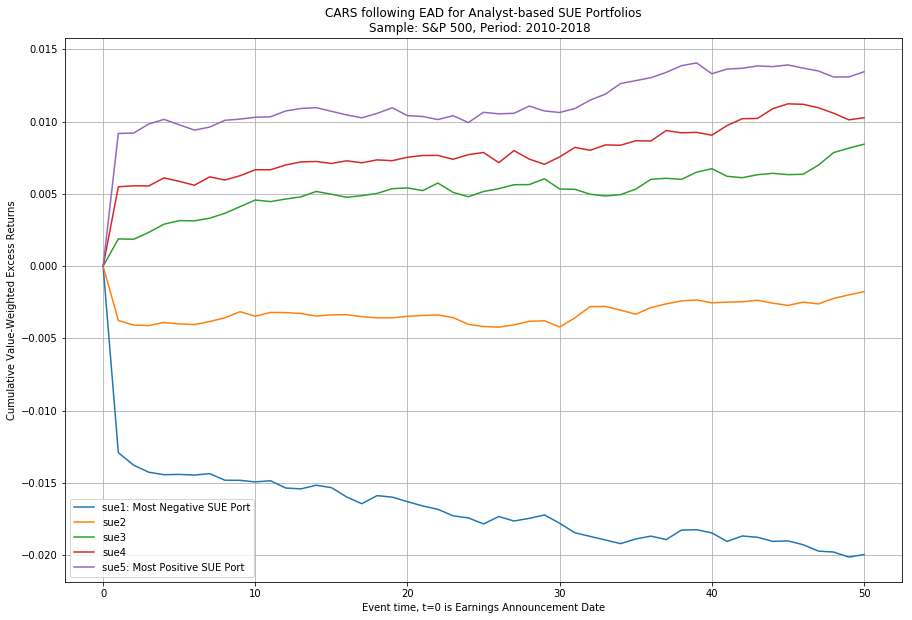

In [18]:
plt.figure(figsize=(15,10))
plt.plot(peadsue3port[['sueport1', "sueport2", "sueport3", "sueport4", "sueport5"]])
plt.title('CARS following EAD for Analyst-based SUE Portfolios\nSample: S&P 500, Period: 2010-2018  ')
plt.legend(['sue1: Most Negative SUE Port', "sue2", "sue3", "sue4", "sue5: Most Positive SUE Port"])
plt.xlabel('Event time, t=0 is Earnings Announcement Date')
plt.ylabel('Cumulative Value-Weighted Excess Returns')
plt.grid()
plt.show()

## References
Abarbanell, J., and Lehavy, R. (2002), “Differences in Commercial Database Reported Earnings: Implications for Empirical Research”, Working Paper, University of North Carolina

Ball, R., and Brown, P (1968), “How Naïve is the Stock Market’s Use of Earnings Information?”, Journal of Accounting and Economics, Vol. 21.

Booth, G., Kallunki, J., and Martikainen, T. (2006), “PEAD and Income Smoothing: Finnish Evidence”, Journal of Business Finance and Accounting, Dec.

Bradshaw, M.T., and Sloan R.G. (2002), “GAAP Versus The Street: An Empirical Assessment of Two Alternative Definitions of Earnings”, Journal of Accounting Research, 40, pp. 41-66.

Kothari, S.P. (2001), “Capital Markets research in accounting”, Journal of Accounting and Economics, 31.

Livnat, J. and Mendenhall, R. (2006), “Comparing the Post-Earnings Announcement Drift for Surprises Calculated from Analyst and Time-Series Forecasts”, Journal of Accounting Research, Vol. 44 No.1.

Lui, W., Strong, M., and Xu, X. (2003), “PEAD in UK”, European Financial Management, Vol. 9.

Mendenhall, R. (2004), “Arbitrage Risk and PEAD”, Journal of Business, Vol. 77

Payne, J., and Thomas, B. (2003), “The Implications of Using Stock-Split Adjusted I/B/E/S data in Empirical Research”, The Accounting Review, 78(4), pp. 1049-1067